# <center> House Price Prediction 🏠📊 </center>

## <center>[Msc. Diego Hurtado](https://www.linkedin.com/in/diegohurtadoo/)</center>

<img src="https://cdn1.intriper.com/wp-content/uploads/2020/12/21113453/home-alone-house.jpg" width="700" height="500">

# 1 <a id='1'>Introduction</a>
[Table of contents](#0.1)

The House Price Prediction dataset consists of information related to residential properties and their corresponding sale prices. The dataset is divided into a training set (train.csv), a test set (test.csv), and additional files providing descriptions and sample submissions.

The target variable of this dataset is the "SalePrice," which represents the property's sale price in dollars. The objective is to develop a predictive model that can accurately estimate the sale price of houses based on their characteristics.

The dataset contains a wide range of features that describe various aspects of the properties, including their physical attributes, location, condition, and other relevant factors. Some of the key features include the building class (MSSubClass), zoning classification (MSZoning), lot size (LotArea), road access type (Street), building style (HouseStyle), overall material and finish quality (OverallQual), number of bedrooms (Bedroom), and many more.

The data provides valuable information for understanding the factors that influence house prices. By analyzing these features and building a predictive model, we can gain insights into the relationships between different attributes and their impact on the property's value.

In this task, I aim to develop a machine learning model that can effectively predict house prices based on the given dataset. By utilizing advanced techniques and algorithms, we can uncover patterns and relationships in the data, leading to accurate price estimations for unseen properties.

The challenge lies in preprocessing the data, handling missing values, transforming categorical features, selecting relevant features, and applying suitable regression algorithms to build a robust prediction model. The performance of the model will be evaluated based on the root mean squared logarithmic error (RMSLE) metric.

Through the analysis of the House Price Prediction dataset, we can gain valuable insights into the real estate market and develop models that can assist in pricing properties accurately, benefiting buyers, sellers, and real estate professionals alike.

# Table of Contents Diego 👨🏻‍💻<a id='0.1'></a>

* [Introduction](#1)
* [Data Modeling ](#2)
    * [Import Packages](#2.1)
    * [Custom Classes](#2.2)
    * [Data Preprocessing](#2.3)
        * [Data Reading](#2.3.1)
        * [EDA](#2.3.2)
        * [Feature Engineering](#2.3.3)
      	* [Missing Values](#2.3.3.1)
    	* [Encoding](#2.3.3.2)
        * [Feature Transformation](#2.3.3.3)
    * [Modeling](#2.4)
        * [XGBoost ](#2.4.1)

# 2 <a id='2'> Data Modeling 📚</a>
[Table of contents](#0.1)

# 2.1 <a id='2.1'>Import Packages📚</a>
[Table of contents](#0.1)

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p

# from ydata_profiling import ProfileReport

from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 2.2 <a id='2.1'>Custom Classes🔍</a>
[Table of contents](#0.1)

In [2]:
class PipelinePricePrediction():
    def __init__(self):
        self.project = 'House Price Prediction '
        
    def get_percent_missing(self, df):
        percent_missing = df.isnull().sum() * 100 / len(df)
        missing_value_df = pd.DataFrame({'column_name': df.columns,
                                         'percent_missing': percent_missing})
        missing_value_df.sort_values('percent_missing', inplace=True)
        
        missing_value_df.reset_index(drop = True , inplace = True)

        return missing_value_df[missing_value_df['percent_missing'] > 0]
    
    
    def unique_counts(self, df):
        """
        Returns the number of unique values and unique values for each feature in the given dataframe.

        Parameters:
        df (pandas.DataFrame): The input dataframe.

        Returns:
        unique_counts_df (pandas.DataFrame): A dataframe containing the feature names, the number of unique values, the unique values, and the data type of each feature.
        """
        unique_counts = df.nunique()
        unique_values = [df[column].unique() for column in df.columns]
        data_types = [str(df[column].dtype) for column in df.columns]
        unique_counts_df = pd.DataFrame({'feature': df.columns, 'unique_count': unique_counts, 'unique_values': unique_values, 'data_type': data_types})
        return unique_counts_df
    
    
    def dataframe_insights(self, df):
        """
        This function provides basic insights about a dataframe.

        Parameters:
        df (pandas dataframe): The dataframe to analyze.

        Returns:
        A dictionary containing basic insights about the dataframe.
        """
        insights = {}
        insights['Number of records'] = len(df)
        insights['Number of columns'] = len(df.columns)
        insights['Columns'] = list(df.columns)
        insights['Number of unique values in each column'] = df.nunique().to_dict()
        insights['Missing values'] = df.isnull().sum().sum()
        insights['Percentage of missing values in each column'] = (df.isnull().sum() / len(df) * 100).round(2).to_dict()
        insights['Data types'] = df.dtypes.to_dict()
        insights['Summary statistics'] = df.describe().to_dict()
        # insights['Correlation matrix'] = df.corr().to_dict()
        insights['Number of duplicated rows'] = len(df[df.duplicated()])
        insights['Duplicate rows'] = list(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).to_dict('index').values())
        return insights

In [3]:
class DataImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy, filler):
        self.strategy = strategy
        self.fill = filler
        """
        Impute missing values.

        """
    def fit(self, X, column, strategy):
        if strategy == 'mean':
            X[column] = X[column].mean()
        elif strategy == 'median':
            X[column] = X[column].median()
        elif strategy == 'mode':
            X[column] = X[column].mode().iloc[0]
        elif strategy == 'zero':
            X[column] = X[column].fillna(0)
        elif strategy == 'none':
            X[column] = X[column].fillna("None")
                
        return X[column]

In [4]:
def plot_distribution(df, column_name):
    fig = px.histogram(df, x=column_name)
    
    fig.update_layout(
        title="Distribution of " + column_name,
        xaxis_title=column_name,
        yaxis_title="Count",
        bargap=0.1,  # Adjust the gap between bars
        showlegend=False,  # Hide the legend
        font=dict(size=12),  # Adjust the font size
        plot_bgcolor="white",  # Set the background color
    )
    
    fig.update_traces(marker=dict(color='#03a8f3'))
        
    fig.show()
    
def is_high_skewness(df, column_name, threshold=1):
    skewness = df[column_name].skew()
    
    if abs(skewness) > threshold:
        print(f"The '{column_name}' column has high skewness.")
    else:
        print(f"The '{column_name}' column does not have high skewness.")
        
def get_high_skewness_features(df, threshold=1):
    high_skewness_features = []
    skewness_values = []
    for column in df.columns:
        skewness = df[column].skew()
        if abs(skewness) > threshold:
            high_skewness_features.append(column)
            skewness_values.append(skewness)
    
    high_skewness_df = pd.DataFrame({'Feature': high_skewness_features, 'Skewness': skewness_values})
    return high_skewness_df

def get_high_kurtosis_features(df, threshold=3):
    high_kurtosis_features = []
    kurtosis_values = []
    for column in df.columns:
        kurtosis = df[column].kurtosis()
        if abs(kurtosis) > threshold:
            high_kurtosis_features.append(column)
            kurtosis_values.append(kurtosis)
    
    high_kurtosis_df = pd.DataFrame({'Feature': high_kurtosis_features, 'Kurtosis': kurtosis_values})
    return high_kurtosis_df

def apply_column_transformation(df, column_name):
    
    skewness = df[column_name].skew()

    if skewness > 1:
        # Apply log transformation
        df[column_name] = np.log1p(df[column_name])

    elif skewness < -1:
        # Apply exponential transformation
        df[column_name] = np.exp(df[column_name])

    # Additional conditional statements for specific column characteristics
    if column_name in ['Street', 'LandSlope', 'ExterQual']:
        # Apply one-hot encoding or ordinal encoding
        df = pd.get_dummies(df, columns=[column_name], drop_first=True)  # Example: One-hot encoding

    elif column_name in ['BsmtCond', 'GarageQual']:
        # Apply specific transformation or encoding for these columns
        # Example: Replace values with numeric codes
        df[column_name] = df[column_name].map({'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0})

    # ... add more conditions and transformations as needed

    return df

def apply_one_hot_encoding(df, categorical_features):
    encoded_df = pd.get_dummies(df, columns=categorical_features, drop_first=True)
    return encoded_df

def rmsle_cv_(model, X, y):
    n_folds = 5
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    rmsle_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        rmsle = np.sqrt(mean_squared_error(np.log1p(y_val), np.log1p(y_pred)))
        rmsle_scores.append(rmsle)

    avg_rmsle = np.mean(rmsle_scores)
    print("Average RMSLE: {:.4f}".format(avg_rmsle))

    return rmsle_scores

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


def rmsle_cv(model):
    n_folds = 5
    
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df_train.values)
    
    rmse= np.sqrt(-cross_val_score(model, df_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    
    return(rmse)

In [5]:
pipeline_prediction = PipelinePricePrediction()

# 2.3.1 <a id='2.3.1'> Data Reading </a>
[Table of contents](#0.1)

In [6]:
df_train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

train_id = df_train['Id']
test_id = df_test['Id']

df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

In [7]:
df_train.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
df_test.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# 2.3.2 <a id='2.3.1'> EDA </a>
[Table of contents](#0.1)

In [9]:
pipeline_prediction.get_percent_missing(df_train)

,column_name,percent_missing
61,Electrical,0.068493
62,MasVnrType,0.547945
63,MasVnrArea,0.547945
64,BsmtFinType1,2.534247
65,BsmtCond,2.534247
66,BsmtQual,2.534247
67,BsmtExposure,2.602740
68,BsmtFinType2,2.602740
69,GarageYrBlt,5.547945
70,GarageQual,5.547945


In [10]:
pd.DataFrame(pipeline_prediction.dataframe_insights(df_train)['Summary statistics'])

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [11]:
high_kurtosis_features = get_high_kurtosis_features(df_train.select_dtypes(exclude=['object']), threshold=3)
high_kurtosis_features

,Feature,Kurtosis
0,LotFrontage,17.452867
1,LotArea,203.243271
2,MasVnrArea,10.082417
3,BsmtFinSF1,11.118236
4,BsmtFinSF2,20.113338
5,TotalBsmtSF,13.250483
6,1stFlrSF,5.745841
7,LowQualFinSF,83.234817
8,GrLivArea,4.895121
9,BsmtHalfBath,16.396642


In [12]:
high_skewness_features = get_high_skewness_features(df_train.select_dtypes(exclude=['object']), threshold=1.5)
high_skewness_features

,Feature,Skewness
0,LotFrontage,2.163569
1,LotArea,12.207688
2,MasVnrArea,2.669084
3,BsmtFinSF1,1.685503
4,BsmtFinSF2,4.255261
5,TotalBsmtSF,1.524255
6,LowQualFinSF,9.011341
7,BsmtHalfBath,4.103403
8,KitchenAbvGr,4.488397
9,WoodDeckSF,1.541376


In [13]:
# ProfileReport(df_train)

feature_y = 'SalePrice'

print(round(df_train[feature_y].quantile(0.0001) / 1000 , 2))
print(round(df_train[feature_y].quantile(0.99) / 1000 , 2))

print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

is_high_skewness(df_train, feature_y, threshold=1.5)
plot_distribution(df_train, feature_y)

34.96
442.57
Skewness: 1.882876
Kurtosis: 6.536282
The 'SalePrice' column has high skewness.



 mu = 180921.20 and sigma = 79415.29



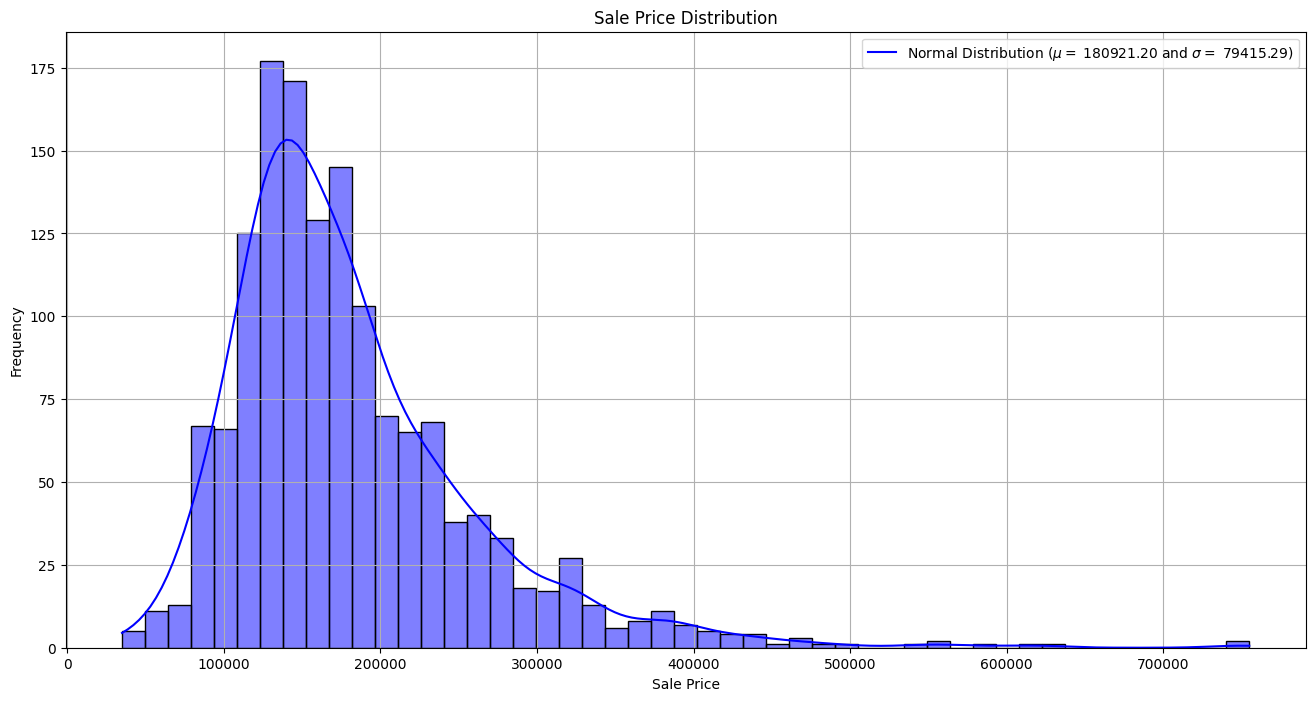

In [14]:
# Plot the histogram
plt.rcParams["figure.figsize"] = [16, 8]
sns.histplot(df_train['SalePrice'], kde=True, color='blue')

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Add labels and title
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.title('Sale Price Distribution')

# Add a legend
plt.legend(['Normal Distribution ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='best')

# Add grid lines
plt.grid(True)

# Show the plot
plt.show()

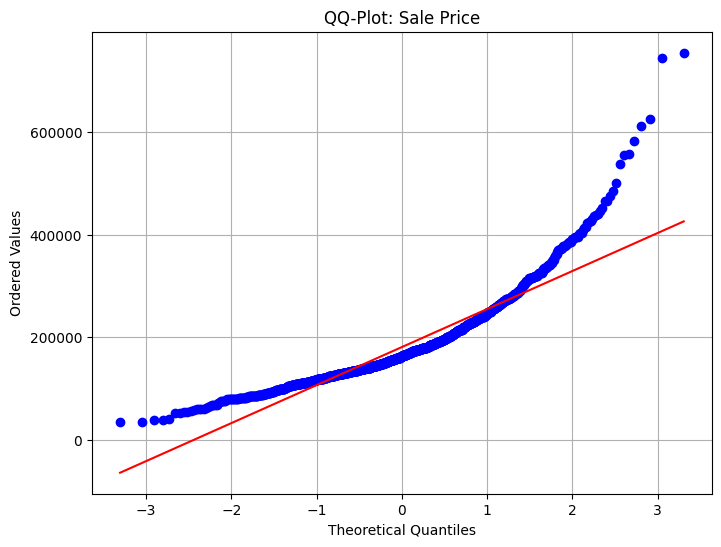

In [15]:
# Create a figure and axes
plt.rcParams["figure.figsize"] = [16, 8]
fig, ax = plt.subplots(figsize=(8, 6))

# Generate QQ-plot
plt.rcParams["figure.figsize"] = [16, 8]
res = stats.probplot(df_train['SalePrice'], plot=ax)

# Add labels and title
ax.set_xlabel('Theoretical Quantiles')
ax.set_ylabel('Ordered Values')
ax.set_title('QQ-Plot: Sale Price')

# Add grid lines
ax.grid(True)

# Show the plot
plt.show()

/tmp/ipykernel_20/469926728.py:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751





 mu = 12.02 and sigma = 0.40



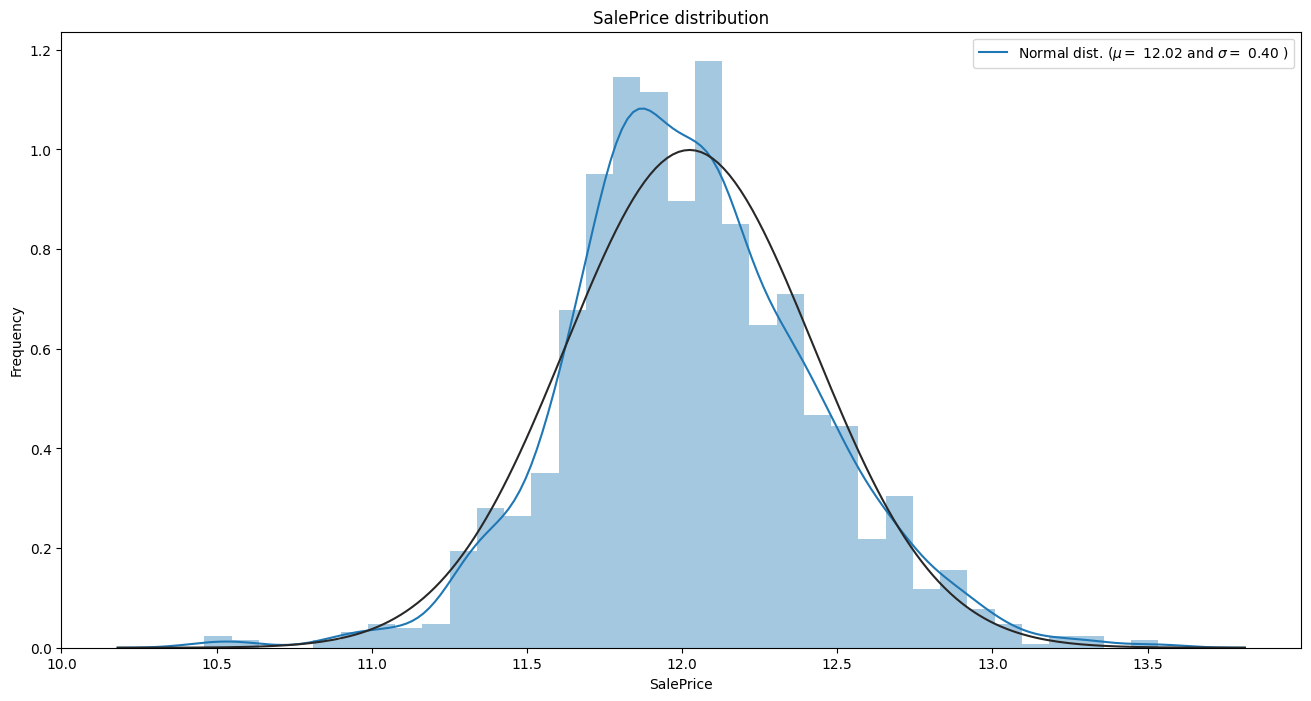

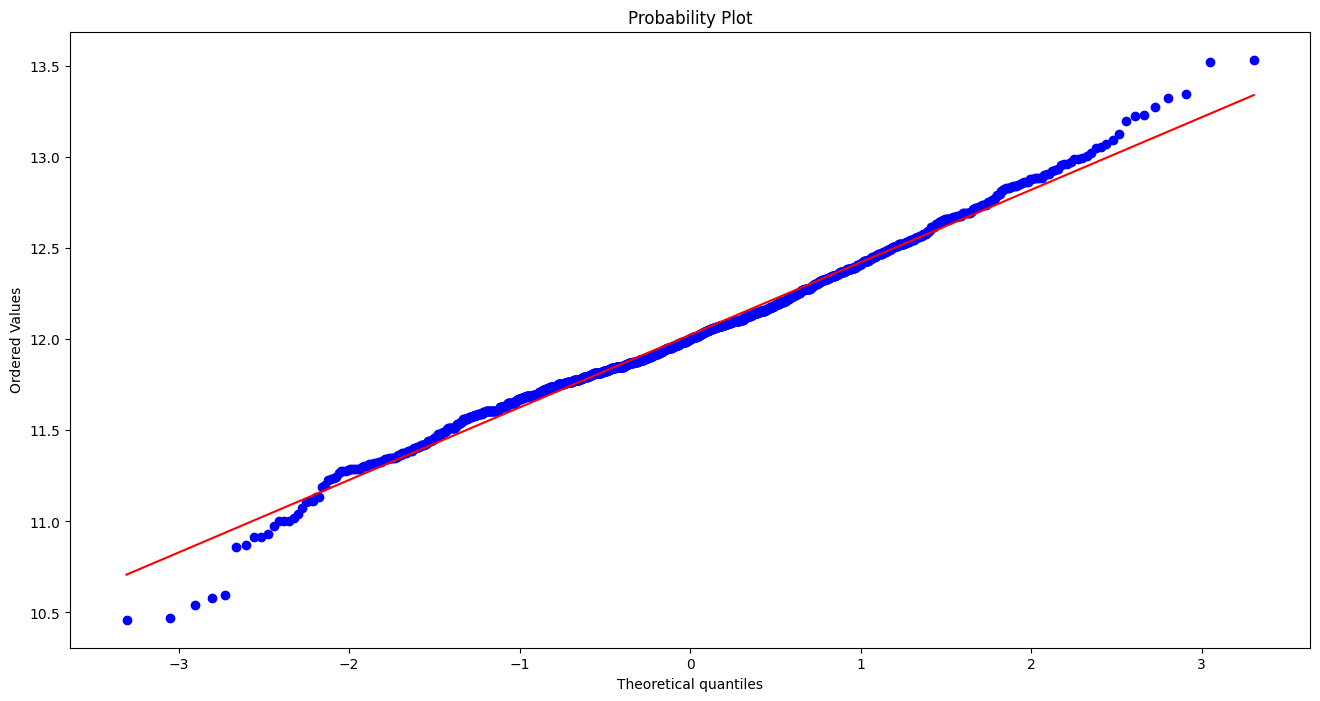

In [16]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])
plt.rcParams["figure.figsize"] = [16, 8]
#Check the new distribution 
sns.distplot(df_train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

In [17]:
is_high_skewness(df_train, feature_y, threshold=1.5)
plot_distribution(df_train, feature_y)

The 'SalePrice' column does not have high skewness.


In [18]:
feature_y = 'LotArea'
is_high_skewness(df_train, feature_y, threshold=1.5)
plot_distribution(df_train, feature_y)

The 'LotArea' column has high skewness.


In [19]:
feature_y = 'ScreenPorch'
is_high_skewness(df_train, feature_y, threshold=1.5)
plot_distribution(df_train, feature_y)

The 'ScreenPorch' column has high skewness.


# 2.3.3 <a id='2.3.3'> Feature Engineering </a>
[Table of contents](#0.1)

In [20]:
ntrain = df_train.shape[0]
ntest = df_test.shape[0]

y_train = df_train.SalePrice.values

df = pd.concat((df_train, df_test)).reset_index(drop=True)
df.drop(['SalePrice'], axis=1, inplace=True)

In [21]:
pipeline_prediction.get_percent_missing(df)

,column_name,percent_missing
45,GarageCars,0.034258
46,GarageArea,0.034258
47,KitchenQual,0.034258
48,Electrical,0.034258
49,SaleType,0.034258
50,Exterior1st,0.034258
51,TotalBsmtSF,0.034258
52,BsmtUnfSF,0.034258
53,Exterior2nd,0.034258
54,BsmtFinSF1,0.034258


# 2.3.3.1 <a id='2.3.3.1'> Missing Values </a>
[Table of contents](#0.1)

In [22]:
imputer = DataImputer(BaseEstimator, TransformerMixin)

df_clean = pd.read_csv('https://raw.githubusercontent.com/DiegoHurtad0/Linear-Regression-Model-Representation-Implementation-From-Scratch-using-Python/main/data/data_cleaning_hp.csv')

df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [23]:
for i in df_clean['fill type'].unique():
    strategy = i
    for j in df_clean[df_clean['fill type'] == i]['column name'].tolist():
        column = j
        print(strategy  + column)
        df[column] = imputer.fit(df, column, strategy)

modeLotFrontage
modeElectrical
modeMSZoning
modeExterior1st
modeExterior2nd
modeKitchenQual
modeFunctional
modeSaleType
noneAlley
noneMasVnrType
noneBsmtQual
noneBsmtCond
noneBsmtExposure
noneBsmtFinType1
noneBsmtFinType2
noneFireplaceQu
noneGarageType
noneGarageFinish
noneGarageQual
noneGarageCond
nonePoolQC
noneFence
noneMiscFeature
zeroMasVnrArea
zeroGarageYrBlt
zeroBsmtFinSF1
zeroBsmtFinSF2
zeroBsmtUnfSF
zeroTotalBsmtSF
zeroBsmtFullBath
zeroBsmtHalfBath
zeroGarageCars
zeroGarageArea


In [24]:
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,60.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,2,2008,WD,Normal
1,20,RL,60.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,0,None,None,None,0,5,2007,WD,Normal
2,60,RL,60.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,None,None,None,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,0,None,None,None,0,2,2006,WD,Abnorml
4,60,RL,60.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,0,None,None,None,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RL,60.0,1936,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,6,2006,WD,Normal
2915,160,RL,60.0,1894,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,4,2006,WD,Abnorml
2916,20,RL,60.0,20000,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,9,2006,WD,Abnorml
2917,85,RL,60.0,10441,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,MnPrv,Shed,700,7,2006,WD,Normal


In [25]:
pipeline_prediction.get_percent_missing(df)

,column_name,percent_missing
78,Utilities,0.068517


# 2.3.3.2 <a id='2.3.3.2'> Encoding </a>
[Table of contents](#0.1)

In [26]:
df = df.drop(['Utilities'], axis=1)

# non-numeric predictors are stored as numbers; convert them into strings
for col in ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']: df[col] = df[col].astype(str)

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df[c].values)) 
    df[c] = lbl.transform(list(df[c].values))
    
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

df['Totalsqr'] = (df['BsmtFinSF1'] + df['BsmtFinSF2'] +
                                 df['1stFlrSF'] + df['2ndFlrSF'])

df['TotalBaths'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                               df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))

df['TotalPorch'] = (df['OpenPorchSF'] + df['3SsnPorch'] +
                              df['EnclosedPorch'] + df['ScreenPorch'] +
                              df['WoodDeckSF'])


# 2.3.3.3 <a id='2.3.3.3'> Feature Transformation </a>
[Table of contents](#0.1)

In [27]:
high_skewness_features = get_high_skewness_features(df.select_dtypes(exclude=['object']), threshold=1.5)
high_skewness_features

,Feature,Skewness
0,LotArea,12.829025
1,Street,-15.508104
2,LandSlope,4.977715
3,MasVnrArea,2.614936
4,ExterQual,-1.802335
5,ExterCond,-2.499003
6,BsmtCond,-2.864057
7,BsmtFinType2,-3.045893
8,BsmtFinSF2,4.148275
9,CentralAir,-3.460801


In [28]:
numeric_feats = df.dtypes[df.dtypes != "object"].index
skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

,Skew
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065
LandSlope,4.975157
KitchenAbvGr,4.302254
BsmtFinSF2,4.146143
EnclosedPorch,4.003891
ScreenPorch,3.946694


In [29]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    df[feat] = boxcox1p(df[feat], lam)

There are 62 skewed numerical features to Box Cox transform


In [30]:
high_skewness_features = get_high_skewness_features(df.select_dtypes(exclude=['object']), threshold=1.5)
high_skewness_features

,Feature,Skewness
0,Street,-15.508104
1,Alley,-2.629396
2,LandSlope,4.534366
3,ExterQual,-2.847525
4,ExterCond,-3.016373
5,BsmtCond,-3.231323
6,BsmtFinType2,-3.773536
7,BsmtFinSF2,2.565799
8,BsmtUnfSF,-1.538998
9,TotalBsmtSF,-3.963311


In [31]:
for i in high_skewness_features['Feature'].tolist():
    print(i)
    df = apply_column_transformation(df, i)

Street
Alley
LandSlope
ExterQual
ExterCond
BsmtCond
BsmtFinType2
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
CentralAir
LowQualFinSF
BsmtHalfBath
KitchenAbvGr
GarageYrBlt
GarageArea
GarageQual
GarageCond
PavedDrive
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
PoolQC
Fence
MiscVal


In [32]:
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,...,TotalSF,Totalsqr,TotalBaths,TotalPorch,Street_2.0760418978713995,LandSlope_0.5483890877780639,LandSlope_0.7858711270694804,ExterQual_2.0760418978713995,ExterQual_3.3013043167270872,ExterQual_4.669083294040686
0,2.885846,RL,5.684507,19.212182,2.076042,1.540963,Lvl,Inside,CollgCr,Norm,...,14.976591,14.781997,1.687259,5.714669,1,0,0,0,1,0
1,2.055642,RL,5.684507,19.712205,2.076042,1.540963,Lvl,FR2,Veenker,Feedr,...,14.923100,14.540127,1.378202,9.010206,1,0,0,0,0,1
2,2.885846,RL,5.684507,20.347241,2.076042,0.000000,Lvl,Inside,CollgCr,Norm,...,15.149678,14.585277,1.687259,5.053371,1,0,0,0,1,0
3,3.011340,RL,5.684507,19.691553,2.076042,0.000000,Lvl,Corner,Crawfor,Norm,...,14.857121,14.076603,1.194318,9.080098,1,0,0,0,0,1
4,2.885846,RL,5.684507,21.325160,2.076042,0.000000,Lvl,FR2,NoRidge,Norm,...,15.852312,15.323415,1.687259,8.831514,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,1.194318,RL,5.684507,14.081426,2.076042,1.540963,Lvl,Inside,MeadowV,Norm,...,13.567978,12.374860,0.982247,0.000000,1,0,0,0,0,1
2915,1.194318,RL,5.684507,14.013314,2.076042,1.540963,Lvl,Inside,MeadowV,Norm,...,13.567978,12.976752,0.982247,4.137711,1,0,0,0,0,1
2916,2.055642,RL,5.684507,22.782058,2.076042,1.540963,Lvl,Inside,Mitchel,Norm,...,14.824355,14.824355,1.194318,10.137338,1,0,0,0,0,1
2917,3.340760,RL,5.684507,20.046557,2.076042,1.540963,Lvl,Inside,Mitchel,Norm,...,13.993617,12.894732,0.982247,6.881187,1,0,0,0,0,1


In [33]:
df.select_dtypes(include=['object'])

,MSZoning,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,Electrical,GarageType,MiscFeature,SaleType,SaleCondition
0,RL,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,SBrkr,Attchd,None,WD,Normal
1,RL,Lvl,FR2,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,CBlock,GasA,SBrkr,Attchd,None,WD,Normal
2,RL,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,SBrkr,Attchd,None,WD,Normal
3,RL,Lvl,Corner,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,BrkTil,GasA,SBrkr,Detchd,None,WD,Abnorml
4,RL,Lvl,FR2,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,SBrkr,Attchd,None,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,RL,Lvl,Inside,MeadowV,Norm,Norm,Twnhs,2Story,Gable,CompShg,VinylSd,VinylSd,None,CBlock,GasA,SBrkr,None,None,WD,Normal
2915,RL,Lvl,Inside,MeadowV,Norm,Norm,TwnhsE,2Story,Gable,CompShg,VinylSd,VinylSd,None,CBlock,GasA,SBrkr,CarPort,None,WD,Abnorml
2916,RL,Lvl,Inside,Mitchel,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,CBlock,GasA,SBrkr,Detchd,None,WD,Abnorml
2917,RL,Lvl,Inside,Mitchel,Norm,Norm,1Fam,SFoyer,Gable,CompShg,VinylSd,VinylSd,None,PConc,GasA,SBrkr,None,Shed,WD,Normal


In [34]:
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
df = apply_one_hot_encoding(df, categorical_features)

In [35]:
df

,MSSubClass,LotFrontage,LotArea,Alley,LotShape,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,GarageType_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,2.885846,5.684507,19.212182,2.076042,1.540963,2.440268,1.820334,14.187527,14.187527,8.059126,...,0,1,0,0,0,0,0,0,1,0
1,2.055642,5.684507,19.712205,2.076042,1.540963,2.259674,2.440268,14.145138,14.145138,0.000000,...,0,1,0,0,0,0,0,0,1,0
2,2.885846,5.684507,20.347241,2.076042,0.000000,2.440268,1.820334,14.184404,14.185966,7.646538,...,0,1,0,0,0,0,0,0,1,0
3,3.011340,5.684507,19.691553,2.076042,0.000000,2.440268,1.820334,14.047529,14.135652,0.000000,...,0,1,0,0,0,0,0,0,0,0
4,2.885846,5.684507,21.325160,2.076042,0.000000,2.602594,1.820334,14.182841,14.182841,9.391827,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,1.194318,5.684507,14.081426,2.076042,1.540963,1.820334,2.259674,14.135652,14.135652,0.000000,...,1,1,0,0,0,0,0,0,1,0
2915,1.194318,5.684507,14.013314,2.076042,1.540963,1.820334,1.820334,14.135652,14.135652,0.000000,...,0,1,0,0,0,0,0,0,0,0
2916,2.055642,5.684507,22.782058,2.076042,1.540963,2.055642,2.259674,14.119786,14.176584,0.000000,...,0,1,0,0,0,0,0,0,0,0
2917,3.340760,5.684507,20.046557,2.076042,1.540963,2.055642,1.820334,14.170316,14.170316,0.000000,...,1,0,0,1,0,0,0,0,1,0


# 2.4 <a id='2.4'> Modeling </a>
[Table of contents](#0.1)

In [36]:
df_train = df[:ntrain]
df_test = df[ntrain:]
y_train

array([12.24769912, 12.10901644, 12.31717117, ..., 12.49313327,
       11.86446927, 11.90159023])

In [37]:
df_train

,MSSubClass,LotFrontage,LotArea,Alley,LotShape,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,GarageType_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,2.885846,5.684507,19.212182,2.076042,1.540963,2.440268,1.820334,14.187527,14.187527,8.059126,...,0,1,0,0,0,0,0,0,1,0
1,2.055642,5.684507,19.712205,2.076042,1.540963,2.259674,2.440268,14.145138,14.145138,0.000000,...,0,1,0,0,0,0,0,0,1,0
2,2.885846,5.684507,20.347241,2.076042,0.000000,2.440268,1.820334,14.184404,14.185966,7.646538,...,0,1,0,0,0,0,0,0,1,0
3,3.011340,5.684507,19.691553,2.076042,0.000000,2.440268,1.820334,14.047529,14.135652,0.000000,...,0,1,0,0,0,0,0,0,0,0
4,2.885846,5.684507,21.325160,2.076042,0.000000,2.602594,1.820334,14.182841,14.182841,9.391827,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2.885846,5.684507,18.960528,2.076042,1.540963,2.259674,1.820334,14.181278,14.182841,0.000000,...,0,1,0,0,0,0,0,0,1,0
1456,2.055642,5.684507,20.994868,2.076042,1.540963,2.259674,2.055642,14.148295,14.164038,7.003881,...,0,1,0,0,0,0,0,0,1,0
1457,3.011340,5.684507,19.476345,2.076042,1.540963,2.440268,2.602594,14.089451,14.192207,0.000000,...,0,0,0,1,0,0,0,0,1,0
1458,2.055642,5.684507,19.760176,2.076042,1.540963,2.055642,2.055642,14.103852,14.176584,0.000000,...,0,1,0,0,0,0,0,0,1,0


In [38]:
y_train

array([12.24769912, 12.10901644, 12.31717117, ..., 12.49313327,
       11.86446927, 11.90159023])

# 2.4.1 <a id='2.4.1'> XGBoost </a>
[Table of contents](#0.1)

In [39]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [40]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[02:49:07] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[02:49:11] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[02:49:16] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[02:49:21] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[02:49:26] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

Xgboost score: 0.1246 (0.0090)



In [41]:
rmsle_scores = rmsle_cv_(model_xgb, df_train.values, y_train)

[02:49:30] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[02:49:35] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[02:49:39] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[02:49:44] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[02:49:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

Average RMSLE: 0.0100


In [42]:
model_xgb.fit(df_train, y_train)
xgb_train_pred = model_xgb.predict(df_train)
xgb_pred = np.expm1(model_xgb.predict(df_test))
print(rmsle(y_train, xgb_train_pred))

[02:49:54] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

0.07984091571158329


In [43]:
xgb_pred

array([127441.88, 165556.47, 187046.56, ..., 172668.97, 121507.08,
       231224.03], dtype=float32)

In [44]:
submission = pd.DataFrame()
submission['Id'] = test_id
submission['SalePrice'] = xgb_pred
submission.to_csv('submission.csv',index=False)

<img src="https://www.vectorlogo.zone/logos/linkedin/linkedin-tile.svg" align='left' alt="plotly" width="60" height="60"/> </a><a> 
## [Msc. Diego Hurtado](https://www.linkedin.com/in/diegohurtadoo/)

<img src="https://www.vectorlogo.zone/logos/github/github-tile.svg" align='left' alt="plotly" width="60" height="60"/> </a><a> 
## [Msc. Diego Hurtado](https://github.com/DiegoHurtad0)

<img src="https://www.vectorlogo.zone/logos/medium/medium-tile.svg" align='left' alt="plotly" width="60" height="60"/> </a><a> 
## [Msc. Diego O’HURTADO](https://medium.com/@diego.hurtado.olivares)

<img src="https://raw.githubusercontent.com/DiegoHurtad0/Covid-19-Dataset-Mexico/master/wave.svg" width="900" height="600">

## [Msc. Diego Hurtado](https://www.linkedin.com/in/diegohurtadoo/)

## “When you are asked if you can do a job, tell ’em, ‘Certainly I can!’ Then get busy and find out how to do it.” — Theodore Roosevelt.